In [43]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import requests
from collections import defaultdict
import networkx as nx
import scipy.stats as stats

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch, K2Score

In [2]:
dataset_path = "recipeNLG.csv"
df = pd.read_csv(dataset_path, index_col = 0)

# TESTING PURPOSES : Cull 99% of the data randomly to ensure faster data processing
# df = df.sample(n = int(len(df) * 0.01), random_state = 42).reset_index(drop = True)

df = df.drop(columns=['link', 'source', 'directions'], errors='ignore')

df['ingredients'] = df['ingredients'].apply(ast.literal_eval)

# Show dataset sample
df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2231142 entries, 0 to 2231141
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   title        object
 1   ingredients  object
 2   NER          object
dtypes: object(3)
memory usage: 68.1+ MB


In [3]:
# We need this list of measurement units for filtering (unfortunate really)
MEASUREMENT_UNITS = [
    'tsp', 'tbsp', 'c', 'cup', 'cups', 'ml', 'l', 'liters', 'liter', 'fl oz', 'fluid ounce',
    'oz', 'ounce', 'ounces', 'g', 'gram', 'grams', 'kg', 'kilogram', 'kilograms', 'lb', 'pound', 'pounds',
    'piece', 'clove', 'slice', 'dash', 'pinch', 'quart', 'pint'
]
unit_pattern = re.compile(r'\b(?:' + '|'.join(MEASUREMENT_UNITS) + r')\b', re.IGNORECASE)
number_pattern = re.compile(r'(\d+(/\d+)?\s*)')

In [4]:
def extract_ingredient_data(ingredient):
    # Edge case / error handling
    if not isinstance(ingredient, str) or ingredient.strip() == "":
        return None, ""

    ingredient_lower = ingredient.lower().strip()

    amount_match = number_pattern.search(ingredient_lower)
    amount = amount_match.group(0).strip() if amount_match else "unknown"

    unit_match = unit_pattern.search(ingredient_lower)
    unit = unit_match.group(0) if unit_match else "unknown"

    cleaned_ingredient = number_pattern.sub('', ingredient_lower)
    cleaned_ingredient = unit_pattern.sub('', cleaned_ingredient)
    cleaned_ingredient = re.sub(r'[^\w\s]', '', cleaned_ingredient)
    cleaned_ingredient = cleaned_ingredient.strip()

    return cleaned_ingredient, f"{amount} {unit}"

In [5]:
def process_ingredients(ingredient_list):
    # Error case / edge case handling
    if not isinstance(ingredient_list, list) or len(ingredient_list) == 0:
        return [], []

    extracted_data = [extract_ingredient_data(ingredient) for ingredient in ingredient_list]
    cleaned, ner = zip(*extracted_data) if extracted_data else ([], [])

    cleaned = [c if c is not None else "" for c in cleaned]
    ner = [n if n is not None else "" for n in ner]

    return list(cleaned), list(ner)

In [6]:
df[['cleaned_ingredients', 'NER']] = df['ingredients'].apply(lambda lst: pd.Series(process_ingredients(lst)))
df['NER'] = df['NER'].apply(lambda x: x if isinstance(x, list) else [])
df = df[df['NER'].apply(lambda ner_list: all("unknown" not in ner for ner in ner_list))]

df = df.reset_index(drop=True)
df = df.drop(columns = ['ingredients'], errors = 'ignore')
df = df.rename(columns={'NER': 'measurements', 'cleaned_ingredients' : 'ingredients'})
df['num_ingredients'] = df['ingredients'].apply(len)

In [7]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170495 entries, 0 to 170494
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            170495 non-null  object
 1   measurements     170495 non-null  object
 2   ingredients      170495 non-null  object
 3   num_ingredients  170495 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.2+ MB


In [8]:
# CPT
ingredient_pairs = Counter()
for ingredients in df['ingredients']:  
    for pair in combinations(set(ingredients), 2): 
        ingredient_pairs[pair] += 1

total_pairs = sum(ingredient_pairs.values())
ingredient_co_occurrence_probs = {pair: count / total_pairs for pair, count in ingredient_pairs.items()}

top_co_occurrences = sorted(ingredient_co_occurrence_probs.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Ingredient Pair Probabilities:")
for pair, prob in top_co_occurrences:
    print(f"{pair}: {prob:.4f}")


Top 10 Ingredient Pair Probabilities:
('salt', 'sugar'): 0.0046
('vanilla', 'sugar'): 0.0031
('salt', 'flour'): 0.0030
('water', 'sugar'): 0.0026
('flour', 'sugar'): 0.0025
('salt', 'pepper'): 0.0023
('milk', 'sugar'): 0.0021
('water', 'salt'): 0.0021
('butter', 'sugar'): 0.0020
('milk', 'salt'): 0.0020


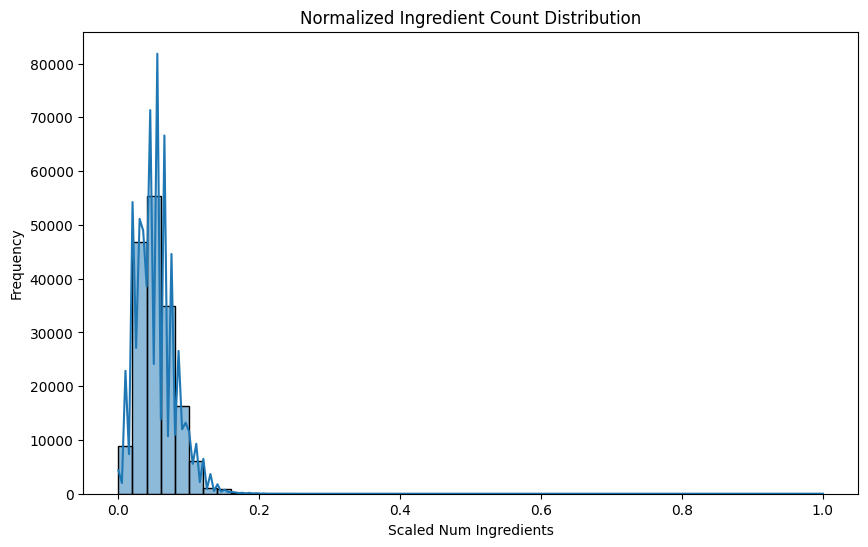

In [9]:
# Scaling to help training
scaler = MinMaxScaler()
df['num_ingredients_scaled'] = scaler.fit_transform(df[['num_ingredients']])

plt.figure(figsize=(10,6))
sns.histplot(df['num_ingredients_scaled'], bins=50, kde=True)
plt.title('Normalized Ingredient Count Distribution')
plt.xlabel('Scaled Num Ingredients')
plt.ylabel('Frequency')
plt.show()

In [10]:
# LOADING USDA FILES HERE
branded_food = pd.read_csv("branded_food.csv")  
food_nutrient = pd.read_csv("food_nutrient.csv")  
nutrient_info = pd.read_csv("nutrient.csv")  

branded_food = branded_food[['fdc_id', 'ingredients', 'serving_size', 'serving_size_unit', 'gtin_upc']]
food_nutrient = food_nutrient[['fdc_id', 'nutrient_id', 'amount']]
nutrient_info = nutrient_info[['id', 'name', 'unit_name']]

food_nutrient = food_nutrient.merge(nutrient_info, left_on='nutrient_id', right_on='id', how='left')
needed_nutrients = ["Energy", "Protein", "Total lipid (fat)", "Carbohydrate, by difference"]
food_nutrient = food_nutrient[food_nutrient['name'].isin(needed_nutrients)]

# Handle duplicate id values
food_nutrient = food_nutrient.groupby(['fdc_id', 'name'], as_index=False).agg({'amount': 'mean'})
food_nutrient_pivot = food_nutrient.pivot(index='fdc_id', columns='name', values='amount').reset_index()
food_nutrient_pivot.columns.name = None  # Remove hierarchical index name
food_nutrient_pivot = food_nutrient_pivot.rename_axis(None, axis=1)  # Fully reset column index

# Simplifying names easier syntaxing
food_nutrient_pivot = food_nutrient_pivot.rename(columns={
    "Energy": "calories",
    "Protein": "protein",
    "Total lipid (fat)": "fat",
    "Carbohydrate, by difference": "carbohydrates"
})
food_df = food_nutrient_pivot.merge(branded_food, on="fdc_id", how="left")

# Culling data set for testing purposes
# food_df = food_df.sample(n = int(len(df) * 0.0001), random_state = 42).reset_index(drop = True)

# Display sample of processed data
print(food_df.head())
print(food_df.shape)


C:\Users\david\AppData\Local\Temp\ipykernel_30196\1255449476.py:2: DtypeWarning: Columns (2,3,4,6,9,12,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  branded_food = pd.read_csv("branded_food.csv")


   fdc_id  carbohydrates  calories  protein    fat  \
0  344604           4.07      24.0     0.81   0.41   
1  344605           4.07      24.0     0.81   0.41   
2  344606           0.00       NaN    23.21   2.68   
3  344607           0.00       NaN    23.21   2.68   
4  344608           0.00       NaN    18.75  15.18   

                                         ingredients  serving_size  \
0  Tomatoes, Tomato Juice, Less Than 2% Of: Salt,...         123.0   
1  Tomatoes, Tomato Juice, Less Than 2% Of: Salt,...         123.0   
2                    White Turkey, Natural Flavoring         112.0   
3                   Turkey Breast, Natural Flavoring         112.0   
4                         Turkey, natural Flavoring.         112.0   

  serving_size_unit        gtin_upc  
0                 g  00072940755050  
1                 g  00072940755043  
2                 g  00642205534517  
3                 g  00642205510276  
4                 g  00642205534500  
(1874041, 9)


In [58]:
# NEEDED PREPROCESSING FOR FASTER PROCESSING WAY TOO SLOW
usda_ingredient_map = defaultdict(list)
for idx, row in food_df.iterrows():
    for ingredient in str(row['ingredients']).split(', '): 
        usda_ingredient_map[ingredient.lower()].append(row)

def match_ingredient_to_usda(ingredient_list):
    matched_nutrition = []
    # total = 0 #Used previously to track progress

    for ingredient in ingredient_list:
        # total += 1 # Progress tracker
        matches = usda_ingredient_map.get(ingredient.lower(), None)
        if matches:
            matched_nutrition.append(matches[0]) 
        else:
            # ERROR HANDLING
            matched_nutrition.append(None)
    return matched_nutrition

df['matched_nutrition'] = df['ingredients'].apply(match_ingredient_to_usda)
df['matched_nutrition'] = df['matched_nutrition'].apply( lambda x: [dict(item) if isinstance(item, pd.Series) else None for item in x] )

In [59]:
def compute_recipe_nutrition(matched_nutrition):
    if not matched_nutrition or all(item is None for item in matched_nutrition):  
        return pd.Series({'calories': np.nan, 'protein': np.nan, 'fat': np.nan, 'carbohydrates': np.nan})
    valid_nutrition = [item for item in matched_nutrition if item and isinstance(item, dict)]

    if not valid_nutrition:  
        return pd.Series({'calories': np.nan, 'protein': np.nan, 'fat': np.nan, 'carbohydrates': np.nan})

    valid_nutrition = [
        {k: item.get(k, 0) for k in ['calories', 'protein', 'fat', 'carbohydrates']}
        for item in valid_nutrition
    ]

    return pd.Series(pd.DataFrame(valid_nutrition).sum())

df[['calories', 'protein', 'fat', 'carbohydrates']] = df['matched_nutrition'].apply(compute_recipe_nutrition)

df = df.dropna()

print(df.head()) # Checking


                              title  \
0               No-Bake Nut Cookies   
1                       Creamy Corn   
2             Double Cherry Delight   
3  Eggless Milkless Applesauce Cake   
4                        Easy Fudge   

                                       measurements  \
0         [1 c, 1/2 c, 1/2 tsp, 1/2 c, 2 tbsp, 3 c]   
1    [2 oz, 1 oz, 1/3 c, 1/2 tsp, 1/2 tsp, 1/4 tsp]   
2            [1 oz, 1/2 c, 1 oz, 2 c, 1/8 tsp, 1 c]   
3  [3/4 c, 1/2 c, 1 c, 3 tsp, 1 tsp, 2 c, 1 c, 1 c]   
4                    [1 oz, 1 oz, 1 oz, 1 c, 1 tsp]   

                                         ingredients  num_ingredients  \
0  [firmly packed brown sugar, evaporated milk, v...                6   
1  [pkg frozen corn, pkg cream cheese cubed, butt...                6   
2  [can dark sweet pitted cherries, ginger ale, p...                6   
3  [sugar, shortening, applesauce, level  soda, e...                8   
4  [can sweetened condensed milk, pkg semisweet c...                5

In [ ]:
# Create a copy of the relevant data
bn_data = df[['title', 'num_ingredients', 'calories', 'protein', 'fat', 'carbohydrates']].copy()

# Compute bin edges based on quantiles (33% and 66%) for each variable

# We need to fix this because the calorie bins are WAY TOO SMALL
# Also the protein bin is WAY TOO SMALL
# ALL THE BINS ARE TOO SMALL WE NEED TO FIX THIS LATER MAYBE WE DIVIDE BY MAXIMUM VALUE / 1000 cals, 100 g, etc.
calorie_edges = [bn_data['calories'].min(), 
                 bn_data['calories'].quantile(0.33), 
                 bn_data['calories'].quantile(0.66), 
                 bn_data['calories'].max()]
protein_edges = [bn_data['protein'].min(), 
                 bn_data['protein'].quantile(0.33), 
                 bn_data['protein'].quantile(0.66), 
                 bn_data['protein'].max()]
fat_edges = [bn_data['fat'].min(), 
             bn_data['fat'].quantile(0.33), 
             bn_data['fat'].quantile(0.66), 
             bn_data['fat'].max()]
carb_edges = [bn_data['carbohydrates'].min(), 
              bn_data['carbohydrates'].quantile(0.33), 
              bn_data['carbohydrates'].quantile(0.66), 
              bn_data['carbohydrates'].max()]

# Print the bin edges for debugging/verification
print("Calorie bin edges:", calorie_edges)
print("Protein bin edges:", protein_edges)
print("Fat bin edges:", fat_edges)
print("Carb bin edges:", carb_edges)


Calorie bin edges: [np.float64(0.0), np.float64(72.0), np.float64(467.0), np.float64(16203.0)]
Protein bin edges: [np.float64(0.0), np.float64(15.18), np.float64(31.849999999999998), np.float64(912.05)]
Fat bin edges: [np.float64(0.0), np.float64(29.8), np.float64(60.34), np.float64(929.38)]
Carb bin edges: [np.float64(0.0), np.float64(88.03209999999999), np.float64(196.71), np.float64(3044.49)]


In [92]:
# Apply custom binning using pd.cut with specified labels and include_lowest flag
bn_data['calorie_category'] = pd.cut(bn_data['calories'], bins=calorie_edges, 
                                     labels=['Low', 'Medium', 'High'], include_lowest=True)
bn_data['protein_category'] = pd.cut(bn_data['protein'], bins=protein_edges, 
                                     labels=['Low', 'Medium', 'High'], include_lowest=True)
bn_data['fat_category'] = pd.cut(bn_data['fat'], bins=fat_edges, 
                                 labels=['Low', 'Medium', 'High'], include_lowest=True)
bn_data['carb_category'] = pd.cut(bn_data['carbohydrates'], bins=carb_edges, 
                                  labels=['Low', 'Medium', 'High'], include_lowest=True)

# At this point you can inspect the new categorical columns directly:
print("\nExample of categorical assignments:")
print(bn_data[['title', 'calorie_category', 'protein_category', 'fat_category', 'carb_category']].head())
print(bn_data.shape)


Example of categorical assignments:
                              title calorie_category protein_category  \
0               No-Bake Nut Cookies              Low           Medium   
1                       Creamy Corn              Low           Medium   
2             Double Cherry Delight           Medium              Low   
3  Eggless Milkless Applesauce Cake             High             High   
4                        Easy Fudge              Low              Low   

  fat_category carb_category  
0          Low           Low  
1       Medium        Medium  
2          Low           Low  
3         High          High  
4          Low           Low  
(149338, 10)


In [93]:
# Now drop the original continuous variables
bn_data = bn_data.drop(columns=['calories', 'protein', 'fat', 'carbohydrates'])

# Print out the head and distributions for verification
print("\nFinal data sample:")
print(bn_data.head())

print("\nCalorie Category Distribution:")
print(bn_data["calorie_category"].value_counts())
print("\nProtein Category Distribution:")
print(bn_data["protein_category"].value_counts())
print("\nFat Category Distribution:")
print(bn_data["fat_category"].value_counts())
print("\nCarb Category Distribution:")
print(bn_data["carb_category"].value_counts())


Final data sample:
                              title  num_ingredients calorie_category  \
0               No-Bake Nut Cookies                6              Low   
1                       Creamy Corn                6              Low   
2             Double Cherry Delight                6           Medium   
3  Eggless Milkless Applesauce Cake                8             High   
4                        Easy Fudge                5              Low   

  protein_category fat_category carb_category  
0           Medium          Low           Low  
1           Medium       Medium        Medium  
2              Low          Low           Low  
3             High         High          High  
4              Low          Low           Low  

Calorie Category Distribution:
calorie_category
Medium    53842
Low       49454
High      46042
Name: count, dtype: int64

Protein Category Distribution:
protein_category
High      50773
Low       49305
Medium    49260
Name: count, dtype: int64

Fat Ca

In [83]:
print("Calorie Category Distribution:")
print(bn_data["calorie_category"].value_counts())

print("\nProtein Category Distribution:")
print(bn_data["protein_category"].value_counts())

print("\nFat Category Distribution:")
print(bn_data["fat_category"].value_counts())

print("\nCarb Category Distribution:")
print(bn_data["carb_category"].value_counts())

print("Missing Values in Categorical Data:")
print(bn_data.isnull().sum())

print("Unique Values in carb_category:", bn_data["carb_category"].unique())

Calorie Category Distribution:
calorie_category
Medium    53842
Low       49454
High      46042
Name: count, dtype: int64

Protein Category Distribution:
protein_category
High      50773
Low       49305
Medium    49260
Name: count, dtype: int64

Fat Category Distribution:
fat_category
High      50774
Low       49520
Medium    49044
Name: count, dtype: int64

Carb Category Distribution:
carb_category
High      50765
Medium    49291
Low       49282
Name: count, dtype: int64
Missing Values in Categorical Data:
num_ingredients     0
calorie_category    0
protein_category    0
fat_category        0
carb_category       0
dtype: int64
Unique Values in carb_category: ['Low', 'Medium', 'High']
Categories (3, object): ['Low' < 'Medium' < 'High']


In [84]:
# Must explain in Readme file why it was necessary
hc = HillClimbSearch(bn_data)
best_model = hc.estimate(scoring_method=K2Score(bn_data))
bayesian_model = BayesianNetwork(best_model.edges())
bayesian_model.fit(bn_data, estimator=MaximumLikelihoodEstimator)


  0%|          | 9/1000000 [00:00<16:22:00, 16.97it/s]


In [85]:
print("Learned Bayesian Network Structure:")
print(bayesian_model.edges())

Learned Bayesian Network Structure:
[('num_ingredients', 'carb_category'), ('calorie_category', 'fat_category'), ('calorie_category', 'carb_category'), ('calorie_category', 'protein_category'), ('fat_category', 'protein_category'), ('fat_category', 'carb_category'), ('fat_category', 'num_ingredients'), ('protein_category', 'num_ingredients'), ('protein_category', 'carb_category')]


In [ ]:
# Consider using this instead of "low medium high" but it works well for english purposes
# mapping = {'Low': 0, 'Medium': 1, 'High': 2}
# for col in ['calorie_category', 'protein_category', 'fat_category', 'carb_category']:
#     bn_data[col] = bn_data[col].map(mapping)

inference = VariableElimination(bayesian_model)

if "carb_category" in bayesian_model.nodes() and "calorie_category" in bayesian_model.nodes():
    query_result = inference.query(variables=["calorie_category"], evidence={"carb_category": "Medium"})
    print("P(calorie_category | carb_category = medium):")
    print(query_result)

if all(var in bayesian_model.nodes() for var in ["protein_category", "fat_category", "carb_category"]):
    query_result_multi = inference.query(variables=["protein_category", "fat_category"], evidence={"carb_category": "High"})
    print("\nP(protein_category, fat_category | carb_category = high):")
    print(query_result_multi)

print("\nMarginal probability distributions for all nodes:")
for node in bayesian_model.nodes():
    query_node = inference.query(variables=[node])
    print(f"\nProbability distribution for {node}:")
    print(query_node)


P(calorie_category | carb_category = medium):
+--------------------------+-------------------------+
| calorie_category         |   phi(calorie_category) |
+==========================+=========================+
| calorie_category(High)   |                  0.3045 |
+--------------------------+-------------------------+
| calorie_category(Low)    |                  0.3247 |
+--------------------------+-------------------------+
| calorie_category(Medium) |                  0.3708 |
+--------------------------+-------------------------+

P(protein_category, fat_category | carb_category = high):
+--------------------------+----------------------+--------------------------------------+
| protein_category         | fat_category         |   phi(protein_category,fat_category) |
+==========================+======================+======================================+
| protein_category(High)   | fat_category(High)   |                               0.6224 |
+--------------------------+--------

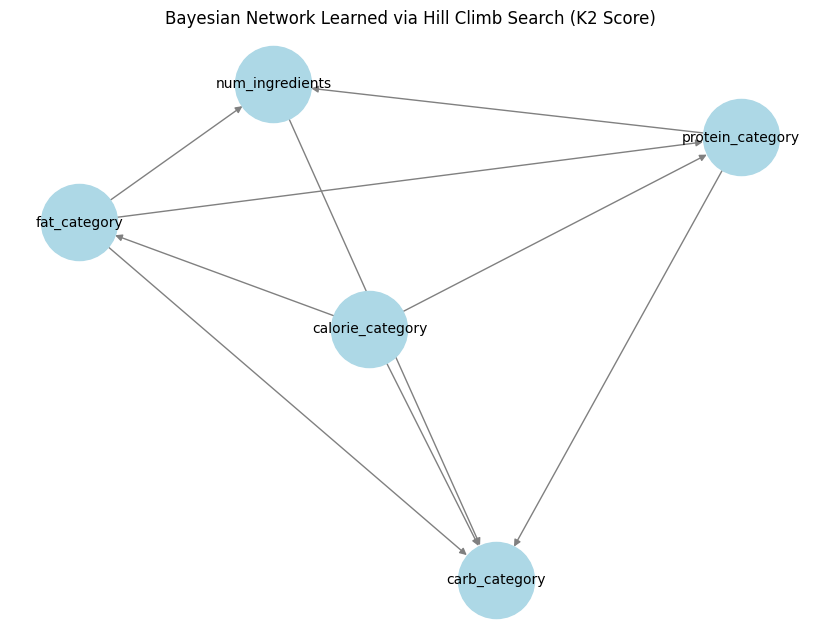

Learned Bayesian Network Edges:
num_ingredients to carb_category
calorie_category to fat_category
calorie_category to carb_category
calorie_category to protein_category
fat_category to protein_category
fat_category to carb_category
fat_category to num_ingredients
protein_category to num_ingredients
protein_category to carb_category


In [88]:
# Bayesian Neywork: Hill Climb Search
plt.figure(figsize=(8, 6))
G = nx.DiGraph(bayesian_model.edges())
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", 
        node_size=3000, font_size=10, arrows=True)

plt.title("Bayesian Network Learned via Hill Climb Search (K2 Score)")
plt.show()

print("Learned Bayesian Network Edges:")
for edge in bayesian_model.edges():
    print(f"{edge[0]} to {edge[1]}")
